In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

num_spot_positions = 200  
num_trials = 20           
spike_rate = 22
duration = 2.985         

simulated_spike_trains = []

for _ in range(num_spot_positions):
    trials = []
    for _ in range(num_trials):
        n_spikes = np.random.poisson(spike_rate * duration)
        spikes = np.sort(np.random.uniform(-0.125, 2.86, size=n_spikes))
        trials.append(spikes)
    simulated_spike_trains.append(trials)

df_simulated = pd.DataFrame({'spike_trains': simulated_spike_trains}).T

def compute_psth_from_spikes(df, bin_size=0.025):
    df = df.T
    spike_times = df['spike_trains']
    num_of_spot_positions = len(df['spike_trains'])
    num_of_trials = len(df['spike_trains'][0])
    all_spike_counts = []
    psth_all = []
    for i in range(num_of_spot_positions):
        spike_counts_i = []
        spikes = df['spike_trains'][i]
        for j in range(num_of_trials):
            bins = np.arange(-0.125, 0.86, 0.025)  
            spike_counts, _ = np.histogram(spikes[j], bins=bins)  
            spike_counts_i.append(sum(spike_counts))  
        all_spike_counts.append(spike_counts_i)

    psth = np.array(all_spike_counts)
    return psth

psth_result = compute_psth_from_spikes(df_simulated)

print("PSTH shape:", psth_result.shape)
print("Example PSTH counts (first 2 spot positions):\n", psth_result[:2])


PSTH shape: (200, 20)
Example PSTH counts (first 2 spot positions):
 [[28 25 31 17 24 20 19 12 31 28 14 21 29 23 18 16 21 20 24 17]
 [28 16 27 22 27 16 21 17 15 16 21 17 21 24 20 13 25 19 18 20]]


In [81]:
a = 0.3  # noise level (std of Gaussian)
b = 0.2  # bias
c = 0.7  # gain
d = -5   # scaling factor

z_matrix = psth_result
normalized_z_matrix = np.zeros(z_matrix.shape)
for j in range(z_matrix.shape[1]):
    min_z = np.min(z_matrix[:, j])
    max_z = np.max(z_matrix[:, j])
    normalized_z_matrix[:, j] = (z_matrix[:, j] - min_z) / (max_z - min_z) if max_z != min_z else 0

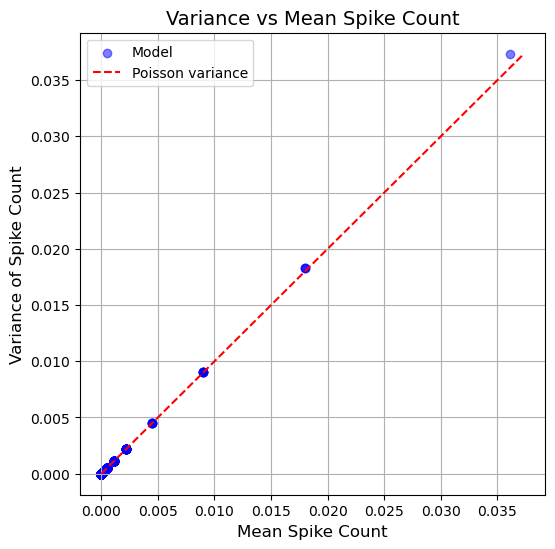

In [82]:
a, b, c, d = 0.6, 0.2, 0.7, -5
z_matrix = psth_result

normalized_z_matrix = np.zeros(z_matrix.shape)
for j in range(z_matrix.shape[1]):
    min_z = np.min(z_matrix[:, j])
    max_z = np.max(z_matrix[:, j])
    normalized_z_matrix[:, j] = (z_matrix[:, j] - min_z) / (max_z - min_z) if max_z != min_z else 0

def integrand_lambda(x, z, a, b, c):
    g = c*z + b
    return d * (1 / (np.sqrt(2 * np.pi) * a)) * np.exp(-x**2 / (2 * a**2)) * (1 / (1 + np.exp(x + g)))

def integrand_variance(x, z, a, b, c):
    g = c*z + b
    return (1 / (np.sqrt(2 * np.pi) * a)) * np.exp(-x**2 / (2 * a**2)) * (1 / (1 + np.exp(x + g)))**2

lambda_matrix = np.zeros(z_matrix.shape)
variance_matrix = np.zeros(z_matrix.shape)

for i in range(z_matrix.shape[0]):
    for j in range(z_matrix.shape[1]):
        z_val = z_matrix[i, j]  
        lambda_val, _ = quad(integrand_lambda, -np.inf, np.inf, args=(z_val, a, b, c))
        var_expect, _ = quad(integrand_variance, -np.inf, np.inf, args=(z_val, a, b, c))
        variance_val = lambda_val + var_expect - lambda_val**2
        lambda_matrix[i, j] = lambda_val
        variance_matrix[i, j] = variance_val


mean_values = lambda_matrix.flatten()
variance_values = variance_matrix.flatten()

plt.figure(figsize=(6, 6))
plt.scatter(np.abs(mean_values), np.abs(variance_values), alpha=0.5, color='blue', label='Model')
plt.plot([0, np.max(abs(variance_values))], [0, np.max(abs(variance_values))], 'r--', label='Poisson variance')

plt.title('Variance vs Mean Spike Count', fontsize=14)
plt.xlabel('Mean Spike Count', fontsize=12)
plt.ylabel('Variance of Spike Count', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()